In [21]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import json
import os
import sys

from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from vvc import config

In [23]:
dataset_folder = config.video_folder

model_name = 'YOLOv3'

experiment_folder = os.path.join(config.base_folder, 'Videos', 'vvc')

video_name = 'CL 53 X CRA 60 910-911'

file_extension = '.mp4.json'

test_file = os.path.join(dataset_folder, 'cvat', video_name + '.xml')
experiment_file = os.path.join(experiment_folder, video_name, model_name + file_extension)

experiment_file

'/home/juan/workspace/Maestria/Videos/vvc/CL 53 X CRA 60 910-911/YOLOv3.mp4.json'

In [24]:
def vott_to_dataframe(json_file):
    test_annotations = {}

    df = pd.DataFrame()

    with open(json_file) as json_data:
        data = json.load(json_data)

        for frame_id, boxes in data['frames'].items():
            if not frame_id in test_annotations:
                test_annotations[frame_id] = {}
            for box in boxes:
                for tag in box['tags']:
                    if not tag in test_annotations[frame_id]:
                        test_annotations[frame_id][tag] = 0
                    test_annotations[frame_id][tag] += 1

    df = pd.DataFrame.from_dict(test_annotations, orient='index')
    df = df.fillna(0)
    df = df.drop(columns=['ignore'])
    df = df.set_index(pd.to_numeric(df.index))
    df = df.sort_index(kind='mergesort')
    
    return df
    
#test = vott_to_dataframe(test_file)
#test.iloc[4:].head()

In [25]:
import xml.etree.ElementTree as ET


def counts_cvat_to_df(in_file):
    '''
    
    '''
    test_annotations = {}
    df = pd.DataFrame()
    
    tree=ET.parse(in_file)
    annotations = tree.getroot()
    
    for track in annotations.iter('track'):
        if track.attrib['label'] == 'vehicle':
            for box in track:
                frame_id = box.get('frame')
                if not frame_id in test_annotations:
                    test_annotations[frame_id] = {}
                    v_type = None
                    lr_side = None
                    fb_side = None
                for attribute in box:
                    if attribute.get('name') == 'type':
                        v_type = attribute.text
                    elif attribute.get('name') == 'LR_side':
                        lr_side = attribute.text
                    elif attribute.get('name') == 'FB_side':
                        fb_side = attribute.text if attribute.text != '__undefined__' else 'back'
                tag = v_type #+ '_' + fb_side + '_' + lr_side
                
                if not tag in test_annotations[frame_id]:
                    test_annotations[frame_id][tag] = 0
                test_annotations[frame_id][tag] += 1
                    

    df = pd.DataFrame.from_dict(test_annotations, orient='index')
    df = df.fillna(0)
    df = df.set_index(pd.to_numeric(df.index))
    df = df.sort_index(kind='mergesort')
    
    return df

test = counts_cvat_to_df(test_file)
test.iloc[100:].head()


,motorbike,bus,truck,car
100,1.0,1.0,0.0,0.0
101,1.0,1.0,0.0,0.0
102,1.0,1.0,0.0,0.0
103,1.0,1.0,1.0,0.0
104,1.0,1.0,1.0,0.0


In [31]:
def vvc_to_df(json_file):
    count_summary = {}
    time_summary = {}

    df = pd.DataFrame()
    
    times = pd.DataFrame()

    with open(json_file) as json_data:
        data = json.load(json_data)
        for frame_id, objects in data['frames'].items():
            
            # Extract counts
            if not frame_id in count_summary:
                count_summary[frame_id] = {}
            
            for obj in objects['objects']:
                tag = obj['tag']
                
                if not tag in count_summary[frame_id]:
                    count_summary[frame_id][tag] = 0
                
                count_summary[frame_id][tag] += 1
                
            # Extract running time
            if not frame_id in time_summary:
                time_summary[frame_id] = {}
                
            for key, value in objects['timestamps'].items():
                time_summary[frame_id][key] = value

    df = pd.DataFrame.from_dict(count_summary, orient='index')
    df = df.fillna(0)
    df = df.set_index(pd.to_numeric(df.index))
    df = df.sort_index(kind='mergesort')
    df = df.reindex(sorted(df.columns), axis=1)
    
    exp = pd.DataFrame()
    
    # Set the values for each perspective
    for column in df.columns:
        for fb_side in ['front', 'back']:
            for lr_side in ['left', 'right']:
                tag = column #+ '_' + fb_side + '_' + lr_side
                exp[tag] = df[column]
    
    exp = exp.sort_index(kind='mergesort')
            
    times = pd.DataFrame.from_dict(time_summary, orient='index')
    times = times.apply(pd.to_datetime)
    original_columns = times.columns
    times['preprocessing'] = times['preprocessing_end'] - times['start']
    times['detection'] = times['detection_end'] - times['preprocessing_end']
    times['tracking'] = times['tracking_end'] - times['detection_end']
    times['postprocessing'] = times['postprocessing_end'] - times['tracking_end']
    times['total'] = times['postprocessing_end'] - times['start']
    times = times.drop(columns=original_columns)
    times = times.astype('timedelta64[ms]')
    
    return exp, times
    
experiment, times = vvc_to_df(experiment_file)

times.iloc[:].head()

,preprocessing,detection,tracking,postprocessing,total
0,5.0,3036.0,0.0,76.0,3119.0
1,11.0,45.0,0.0,4.0,62.0
10,6.0,40.0,0.0,4.0,52.0
100,6.0,39.0,0.0,3.0,50.0
1000,9.0,56.0,0.0,5.0,71.0


In [28]:
def calc_precision(test, experiment): 
    
    # Combine using function    
    min_combined = test.combine(experiment, np.minimum, fill_value=0)
    
    max_combined = test.combine(experiment, np.maximum, fill_value=0)
        
    error = min_combined.div(max_combined)
    
    error[max_combined == 0] = 1

    precision = error
    precision.sort_index(inplace=True, kind='mergesort')

    return precision

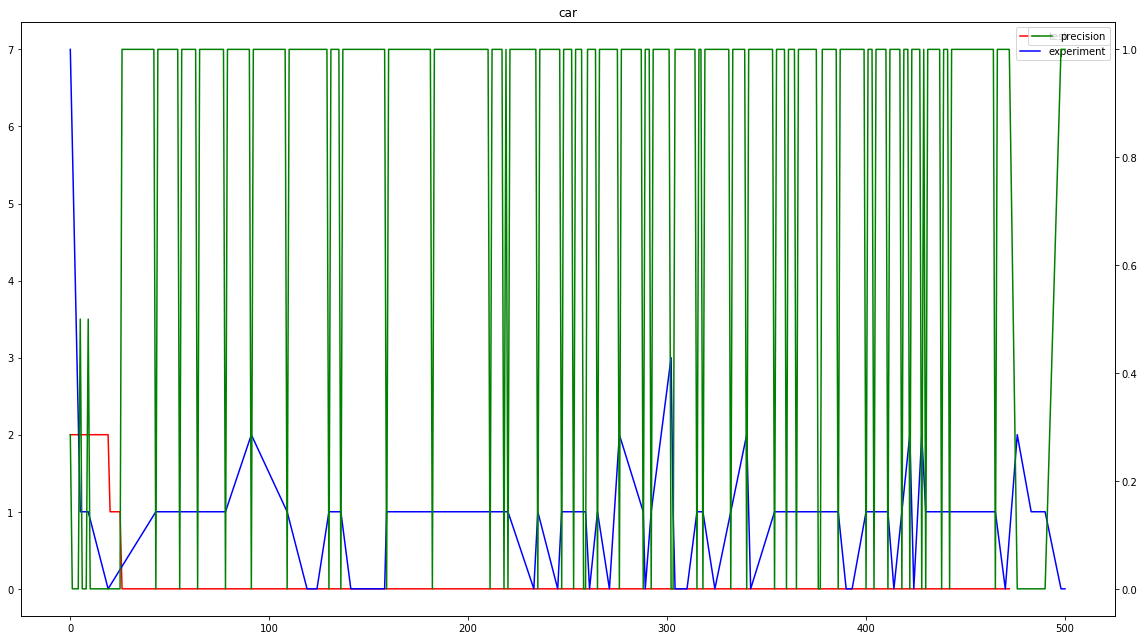

In [30]:
precision = calc_precision(test, experiment)

def plot_precision(vehicle='car', max_index=500):

    sub_test = test.loc[test.index <= max_index, vehicle]
    sub_predicted = experiment.loc[experiment.index <= max_index, vehicle]
    sub_precision = precision.loc[precision.index <= max_index, vehicle]

    fig, ax = plt.subplots(figsize=(16, 9))

    plt.title(vehicle)

    ax.plot(sub_test.index, sub_test, label='test', color='r')

    ax.plot(sub_predicted.index, sub_predicted, label='experiment', color='b')

    ax2 = ax.twinx()

    ax2.plot(sub_precision.index, sub_precision, label='precision', color='g')

    ax.legend()

    ax2.legend()

    plt.tight_layout()

    
plot_precision()

In [20]:
test = counts_cvat_to_df(test_file)

avg_precision = pd.DataFrame(index=test.columns)

avg_fps = pd.DataFrame(index=['1066x600' ])
avg_time = pd.DataFrame(index=['preprocessing', 'detection', 'tracking', 'postprocessing'])

for model in config.models:
    experiment_folder = os.path.join(config.base_folder, 'Videos', 'vvc', video_name)
    experiment_file = os.path.join(experiment_folder, model + '.mp4.json')
    
    experiment, times = vvc_to_df(experiment_file)
    
    precision = calc_precision(test, experiment)
    
    mean_precision = precision.mean().to_frame(model)
    
    avg_precision = avg_precision.join(mean_precision)
    
    # times
    
    mean_time = times[avg_time.index].mean().to_frame(model)
    
    avg_time = avg_time.join(mean_time)
    
    # fps
    
    total = times['total']
    
    fps = (total.count() / total.sum())*1000
        
    avg_fps[model] = fps


# dispay
display(avg_precision)

display(avg_time)

avg_fps

FileNotFoundError: [Errno 2] No such file or directory: '/home/juan/workspace/Maestria/Videos/vvc/CL 53 X CRA 60 910-911/RetinaNet-ResNet50.mp4.json'

<Figure size 432x288 with 0 Axes>

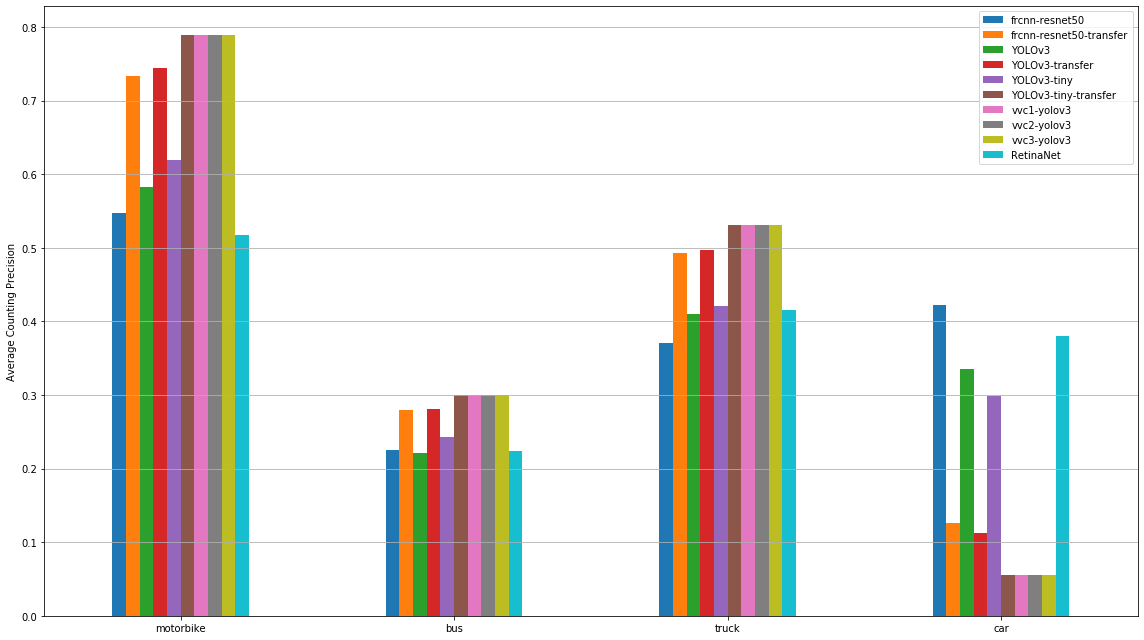

In [23]:
plt.figure()

ax = avg_precision.plot.bar(figsize=(16, 9), rot=0)

plt.grid(axis='y')

ax.set_ylabel('Average Counting Precision')

plt.tight_layout()

fig = ax.get_figure()
fig.savefig('./img/avg_precision.png')
fig.savefig('./img/avg_precision.tif', dpi=300)

<Figure size 432x288 with 0 Axes>

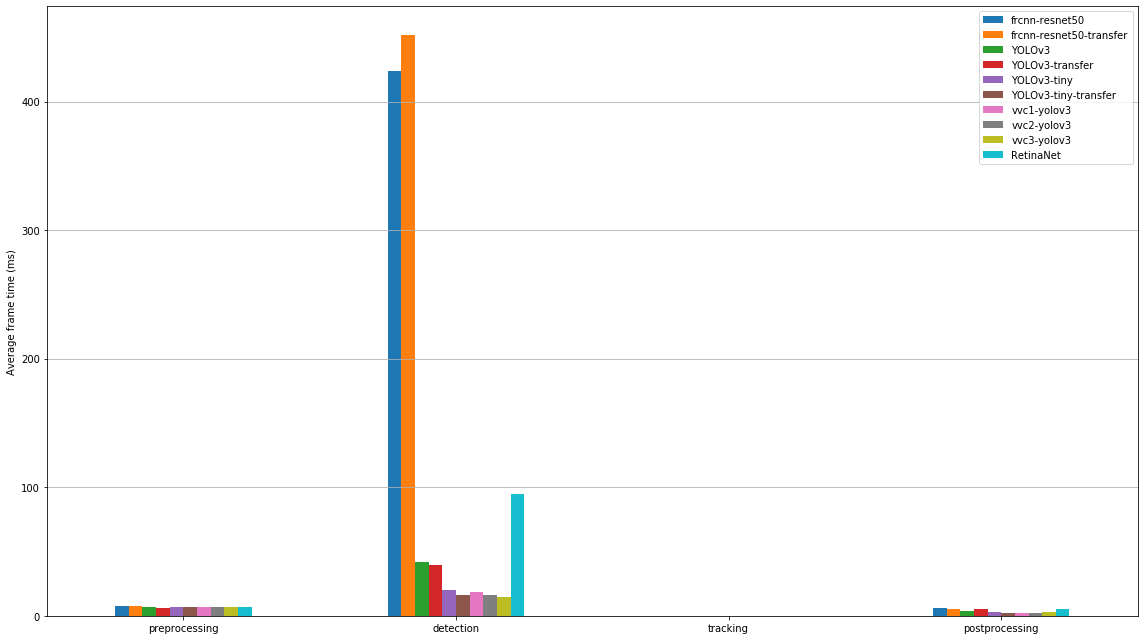

In [27]:
from matplotlib.ticker import AutoLocator, ScalarFormatter

plt.figure()

ax = avg_time.plot.bar(figsize=(16, 9), rot=0)

plt.grid(axis='y')

ax.set_ylabel('Average frame time (ms)')

plt.tight_layout()

fig = ax.get_figure()
fig.savefig('./img/avg_time.png')

<Figure size 432x288 with 0 Axes>

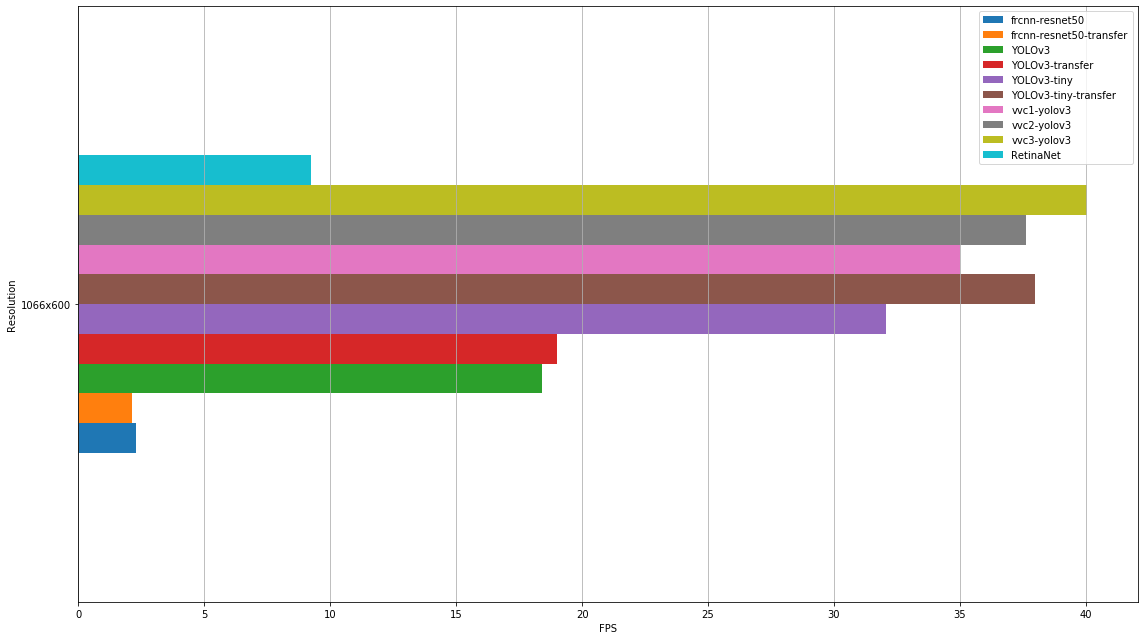

In [25]:
plt.figure()

ax = avg_fps.plot.barh(figsize=(16, 9))

plt.grid(axis='x')

ax.set_ylabel('Resolution')
ax.set_xlabel('FPS')

plt.tight_layout()

fig = ax.get_figure()
fig.savefig('./img/fps.png', dpi=300)